# Quantum Cryptography and Certifying Graph States

## Blind Quantum Computing

Blind quantum computing is an area of quantum cryptography which let's a client (Alice), without sohpisticated quantum computing technologies, to transmit her computation to a server (Bob), who can perform her computation on his quantum computer. Blind quantum computing allows one to perform such transaction while protecting privacy. In this notebook we will discuss using graph states for a particular blind quantum computing protocol. 

## Stabilizer Groups for Graph States

Before we get into verifying quantum computations, let's review graph states and their stabilizer groups. A **graph state**, as we have defined in the chapter on entanglement and the chapter on error correction, are constructed from a graph. Given some (simple) graph $G$, we construct the graph state by first putting all qubits into the $|+\rangle$ state by applying the Hadamard gate to all of the qubits. Then, for each edge, we apply a corresponding controlled-$Z$ gate between the two qubits corresponding to the two vertices that are connected by that edge. Recall from our previous chapter on error correction and stabilizer codes that graph states have stabilizer generators of the form

\begin{align}
S_v = X_v \otimes \left( \bigotimes_{n \in Adj(v)} Z_u \right)
\end{align}

where $X_v$ is the Pauli-$X$ gate applied to the qubit corresponding to the vertex (node) $v$ of the graph $G$. The set $Adj(v)$ is the set of all vertices connected to $v$ by an edge, i.e. the vertices *adjacent* to $v$. The operators $Z_u$ are the corresponding Pauli-$Z$ gates applied to the corresponding qubits. The set of operators $\{S_v\}_{v \in V}$ gives a complete set of generators for the stabilizer group of the graph state $|G\rangle$. The *group* of operators (gates generated by these is denoted by 

\begin{align}
S_G = \langle S_0, S_1, ..., S_N \rangle.
\end{align}

Here $S_j = S_v$ for some vertex $v \in V$, and the number of vertices is $|V|=N$. So we assume we have an index set $\{0, 1, ..., N-1\}$ labeling the vertices of the graph. There are a total of $2^N$ elements in the group $S_G$. 

Let's generate a graph state using our function `graph_state_measure()` from the previous chapters on entanglement and error correction, and stabilizer codes. First we will need to import a few things. NetworkX will help with creating and drawing graphs. QISKit will be good for creating quantum circuits, running them on quantum computer backends, and visualizing them. NumPy will be useful for linear algebra and testing equality of state vectors and other matrix and array type objects. 

In [1]:
import networkx as nx
import numpy as np
from qiskit import *
from qiskit.visualization import plot_bloch_multivector
%matplotlib inline

Next, let's define the `graph_state_measure()` function, which creates a quantum circuit based on some input graph $G$ and also add a classical register for storing the measurement outcomes. 

In [2]:
def graph_state_measure(G):
    # Create a quantum register based on the number of nodes in G
    qr = QuantumRegister(len(G.nodes))
    cr = ClassicalRegister(len(G.nodes))
    # Create a circuit using the quantum register
    circ = QuantumCircuit(qr, cr)
    # For each vertex, apply a Hadamard gate
    for vertex in G.nodes:
        circ.h(vertex)
    # For each edge e={x,y} apply a controlled-Z gate on its vertices
    for x,y in G.edges:
        circ.cz(x,y)
    return circ

Next, let's define a graph $G$, with three vertices, and two edges. So $G$ will be define by its vertex set and edge set, 

\begin{align}
V &= \{0,1,2\}\\
E &= \{(0,1), (1,2)\}.
\end{align}

/Users/amelieschreiber/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


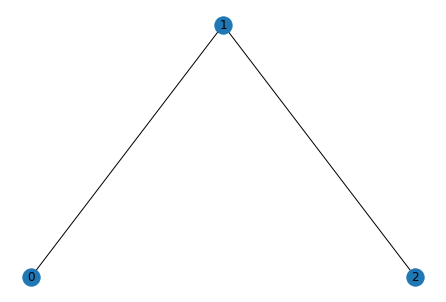

In [3]:
G = nx.Graph()
G.add_nodes_from([0,1,2])
G.add_edges_from([(0,1), (1,2)])
nx.draw_spectral(G, with_labels=True)

Next, we create our graph state circuit using our input graph $G$ and the function `graph_state_measure()`, and draw the circuit using QISKit. 

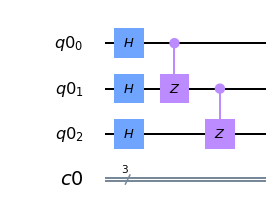

In [4]:
qc = graph_state_measure(G)
qc.draw(output='mpl')

We would like to now test out the three stabilizer generators for the stabilizer group of our graph state. The stabilizer generators are

\begin{align}
S_0 = X_0 \otimes Z_1 \otimes I_3 &= X_0Z_1I_3\\
S_1 = Z_0 \otimes X_1 \otimes Z_2 &= Z_0X_1Z_2\\
S_2 = I_0 \otimes Z_1 \otimes X_2 &= I_0Z_1X_2. 
\end{align}

Recall that the subscript in the notation above corresponds to the qubit we are operating on with that particular gate, and this also corresponds to a particular node (vertex) in the graph $G$. A different labeling of the vertices of our graph will produce a different but equivalent graph state on a QISKit circuit. To test out stabilizers, first let's run the circuit above on the `statevector_simulator` backend in QISKit, and print off the state vector.

In [5]:
# Tell Qiskit how to simulate our circuit
backend = Aer.get_backend('statevector_simulator') 
# Do the simulation, returning the state vector
out_state = execute(qc,backend).result().get_statevector() 
# Display the output state vector
out_state

array([ 0.35355339+0.j,  0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,
        0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,  0.35355339+0.j])

Notice, since we have $3$ qubits we have a $2^3 = 8$ dimensional state vector of amplitudes describing the state of the qubits after we run the graph state circuit. Now, let's apply one of the stabilizers to the circuit and run it again. Here, we will apply $S_0 = X_0Z_1I_2$. 

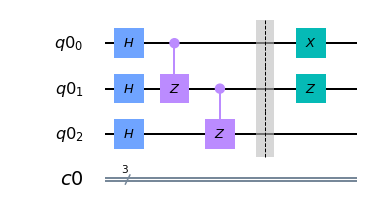

In [6]:
qc.barrier()
qc.x(0)
qc.z(1)
qc.draw(output='mpl')

Running this on the backend we get a new state vector `out_state2`. 

In [7]:
# Tell Qiskit how to simulate our circuit
backend = Aer.get_backend('statevector_simulator') 
# Do the simulation, returning the state vector
out_state2 = execute(qc,backend).result().get_statevector() 
# Display the output state vector
out_state2

array([ 0.35355339+0.j,  0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,
        0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,  0.35355339+0.j])

Remember, we use the `np.isclose()` function in Python with relative tolerance $10^{-5}$ and absolute tolerance $10^{-8}$. If we use the `==` or `np.testing.assert_array_equal()` function, due to round off errors we might get a False outcome. 

In [8]:
np.isclose(out_state, out_state2, rtol=1e-05, atol=1e-08, equal_nan=False)

array([ True,  True,  True,  True,  True,  True,  True,  True])

Since the test showed that these two state vectors are equal (within some rounding error tolerance), we know that 

\begin{align}
S_0|G\rangle = |G\rangle.
\end{align}

In other words, we have verified that $S_0$ is indeed a stabilizer generator for the stabilizer group of the graph state. Let's text the stabilizer generator $S_1 = Z_0X_1Z_2$. 

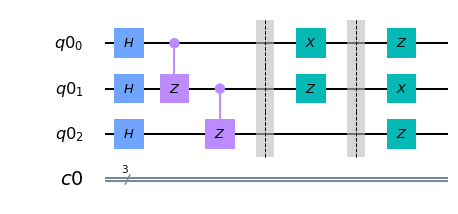

In [9]:
qc.barrier()
qc.z(0)
qc.x(1)
qc.z(2)
qc.draw(output='mpl')

Running this circuit on the backend, we get a new state vector `out_state3`, which we can compare to `out_state` (or to `out_state2`). 

In [10]:
# Tell Qiskit how to simulate our circuit
backend = Aer.get_backend('statevector_simulator') 
# Do the simulation, returning the state vector
out_state3 = execute(qc,backend).result().get_statevector() 
# Display the output state vector
out_state3

array([ 0.35355339+0.j,  0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,
        0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,  0.35355339+0.j])

Testing for equality within our chosen error margins we get the following.

In [11]:
np.isclose(out_state, out_state3, rtol=1e-05, atol=1e-08, equal_nan=False)

array([ True,  True,  True,  True,  True,  True,  True,  True])

So, indeed $S_1$ is a stabilizer generator for the stabilizer group of the graph state $|G\rangle$. Finally, let's test $S_2 = I_0Z_1X_2$. 

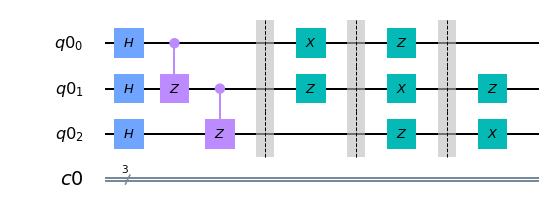

In [12]:
qc.barrier()
qc.z(1)
qc.x(2)
qc.draw(output='mpl')

In [13]:
# Tell Qiskit how to simulate our circuit
backend = Aer.get_backend('statevector_simulator') 
# Do the simulation, returning the state vector
out_state4 = execute(qc,backend).result().get_statevector() 
# Display the output state vector
out_state4

array([ 0.35355339+0.j,  0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,
        0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,  0.35355339+0.j])

In [14]:
np.isclose(out_state, out_state4, rtol=1e-05, atol=1e-08, equal_nan=False)

array([ True,  True,  True,  True,  True,  True,  True,  True])

## Verification Protocol

Okay, now that we have a good review of stabilizer generators for the stabilizer groups of graph states, we would like to talk about *blind quantum computing* for quantum cryptography. Suppose we have a client Alice, who wants to send her computation to a server owned by Bob, who has a quantum computer. She wants to do so securely so that her privacy is protected. She starts by preparing $2k+1$ copies of the graph state $|G\rangle$. These copies will be denoted by $|G\rangle^{\otimes 2k+1}$. Alice uses randomly chosen $2k$-copies of $|G\rangle^{\otimes 2k+1}$ to check the stabilizers $S_v$, where $v \in V$ are vertices. The remaining circuit is used for her computation. The details of the protocol are taken from ["Verifiable measurement-only blind quantum computing with stabilizer testing"](https://arxiv.org/pdf/1505.07535.pdf) and are as follows:

### Server's State Preparation Protocol

1. The server (Bob), assumed to be honest, generates $|G\rangle^{\otimes 2k+1}$, i.e. $2k+1$ copies of the $n$-qubit graph state. We assume that the graph $G$ is bipartite (so its vertices can be colored black and white, with no black vertices connect by an edge, and no white vertices connected by an edge). Call the white vertices $W$, and the black vertices $B$. Bob sends each qubit of $|G\rangle^{\otimes 2k+1}$, one by one to the client Alice. We will also have an *"Evil Bob"*, which is assumed to be a dishonest server. Evil Bob can generate any $n(2k + 1)$-qubit state $|\psi\rangle$ instead of $|G\rangle^{\otimes 2k+1}$.

2. Alice divides 2k + 1 blocks of n qubits into three groups *by random choice*. 
    - The first group consists of $k$ blocks of $n$ qubits. 
    - The second group consists of $k$ blocks of $n$ qubits. 
    - The third group consists of a single block of $n$ qubits.
    
    
3. Alice uses the third group for her computation. Other blocks are used for the test, which will be explained later.

4. If Alice passes the test, she accepts the result of the computation performed on the third group.

![verify.png](verify.png)

In the figure above, the **Raussendorf-Harrington-Goyal lattice** or the **RHG-lattice** is a *"resource state"*, which is a graph state. 

### The Client Alice's Test

For each block of the first and second groups mentioned in the preparation protocol, Alice performs the following test. 

1. For each block of the first group, Alice measures qubits of $W$ in the $Z$-basis and qubits of $B$ in the $X$-basis.

2. For each block of the second group, Alice measures qubits of $B$ in the $Z$-basis and qubits of $W$ in the $X$-basis.

3.  If the measurement outcomes in the $X$-basis coincide with the values predicted from the outcomes in the $Z$-basis (in terms of the stabilizer relations), then the test is passed. If any outcome in the $X$-basis that violates the stabilizer relations is obtained, Alice rejects.

![lattice_bipartite_measure.png](lattice_bipartite_measure.png)

## Bipartite Graphs in NetworkX

Before moving on let's look at some examples of using bipartite graphs in NetworkX. In order to create bipartite graphs in NetworkX, we will need the following import. 

In [15]:
from networkx.algorithms import bipartite

Now, let's create a bipartite graph. This will be the **complete bipartite graph** $K_{4,3}$. 

In [16]:
K = nx.Graph()
# Add nodes with the node attribute "bipartite"
K.add_nodes_from([0, 1, 2, 3], bipartite=0)
K.add_nodes_from([4,5,6], bipartite=1)
# Add edges only between nodes of opposite node sets
K.add_edges_from([(0, 4), (0, 5), (0, 6), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6)])

By convention, the vertices labeled "$0$" will be white, and the nodes labeled "$1$" will be black. This corresponds to the set $W$ and $B$ in the description of the blind quantum computing protocol. So long as the graph $B$ is connected, we have a function in NetworkX that separates the $W$ nodes from the $B$ nodes. Just to be safe, let's test that $B$ is indeed connected. 

In [17]:
nx.is_connected(K)

True

The following function allows us to separate $W$ nodes from $B$ nodes. 

In [18]:
white_nodes, black_nodes = bipartite.sets(K)

In [19]:
print(white_nodes)

{0, 1, 2, 3}


In [20]:
print(black_nodes)

{4, 5, 6}


In [21]:
print(bipartite.sets(K))

({0, 1, 2, 3}, {4, 5, 6})


This will be incredibly helpful if we want to write function that perform different basis measurements on different colored vertices of our graph! As with a typical graph, we can print the edges. 

In [22]:
print(K.edges)

[(0, 4), (0, 5), (0, 6), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6)]


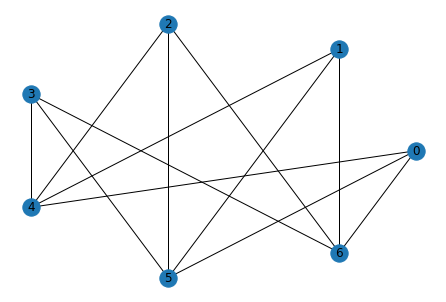

In [23]:
nx.draw_circular(K, with_labels=True)

## Bipartite $X$-Basis and $Z$-Basis Measurements

Now that we have an idea of how to create and manipulate bipartite graphs in NetworkX, we want to write a function that implements a bipartite graph states. We also want to write two measurement function that will measure in the $X$-basis in the white nodes, and in the $Z$-basis on the black notes. We also want to write a second function that will measure in the $Z$-basis on the white nodes, and in the $X$-basis on the white nodes. This will help us implement the protocols of blind quantum computing mentioned above.  

### Bipartite Graph State Creation

To start with, we will need to define a new function to construct graph states for the bipartite case. It will need to handle the new structure and iterate Hadamard gates over two sets of vertices, "$W$" and "$B$". Let's do that now. 

In [24]:
def bipartite_graph_state(B):
    # Create a quantum register based on the number of nodes
    # in W + the number of nodes in B (= total number of nodes in G)
    white_nodes, black_nodes = bipartite.sets(B)
    qr = QuantumRegister(len(black_nodes)+len(white_nodes))
    cr = ClassicalRegister(len(black_nodes)+len(white_nodes))
    # Create a circuit using the quantum register
    circ = QuantumCircuit(qr, cr)
    # For each vertex in W, apply a Hadamard gate
    for vertex in white_nodes:
        circ.h(vertex)
    # For each vertex in B, apply a Hadamard gate
    for vertex in black_nodes:
        circ.h(vertex)
    # For each edge e={x,y} apply a controlled-Z gate on its vertices
    for x,y in B.edges:
        circ.cz(x,y)
    return circ

Now, let's test this out on a very simple bipartite graph. Let's say $B$ is given by the sets

\begin{align}
W &= \{0, 2\}\\
B &= \{1\}\\
E &= \{(0,1), (1,2)\}.
\end{align}

Let's draw this graph now. It will look the same as the graph $G$ we defined above. 

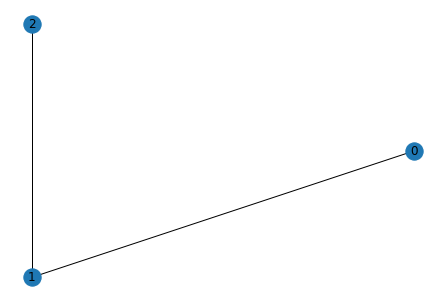

In [25]:
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from([0, 2], bipartite=0)
B.add_nodes_from([1], bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from([(0,1), (1,2)])
nx.draw_circular(B, with_labels=True)

We will divide the nodes into the sets $W$ and $B$ as follows. 

In [26]:
black_nodes, white_nodes = bipartite.sets(B)
print(white_nodes)

{1}


In [27]:
print(black_nodes)

{0, 2}


Okay, now let's create the corresponding (bipartite) graph state using the function `bipartite_graph_state()`. 

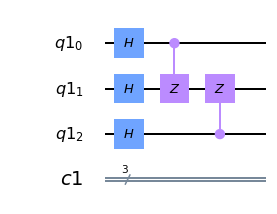

In [28]:
bcirc = bipartite_graph_state(B)
bcirc.draw(output='mpl')

Notice how this graph state is slightly different from, but still equivalent to, the graph state for the graph $G$ that we defined at the beginning of the article. The controlled-$Z$ gates are connected in a slightly different way due to the way the vertices (and thus the qubits) have been partitioned. Now, we want to define a function that will measure the circuit in the $X$-basis on the white nodes, and in the $Z$-basis on the black nodes. First, we define the `x_measurement()` function that performs an $X$-basis measurement on a given qubit, and stores the result in a specified classical bit. Remember from earlier lectures that $H = H^{\dagger}$ and that $HZH^{\dagger} = HZH = X$, so conjugation by the Hadamard gate converts a $Z$-basis measurement into and $X$-basis measurement. 

In [29]:
def x_measurement(circuit,qubit,cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    circuit.h(qubit)
    circuit.measure(qubit, cbit)
    circuit.h(qubit)
    return circuit

Okay, now we define our function `x_measure_white()` that measures a given circuit in the $X$-basis on the white nodes, and in the $Z$-basis on the black nodes. It takes as input a bipartite graph $B$ and an instance of the corresponding graph state `circuit`, and measures in the appropriate bases on that circuit. Be sure the circuit you input as your second argument is actually a graph state you created from the graph $B$ you input as your first argument. 

In [30]:
def x_measure_white(B, circuit):
    white_nodes, black_nodes = bipartite.sets(B)
    circuit.barrier()
    for vertex in black_nodes:
        circuit.measure(vertex, vertex)
    circuit.barrier()
    for vertex in white_nodes:
        x_measurement(circuit, vertex, vertex)
    return circuit

Next, we define our function `x_meas_black_circ()` that measures a given circuit in the $X$-basis on the black nodes, and in the $Z$-basis on the white nodes. It takes as input a bipartite graph $B$ and an instance of the corresponding graph state `circuit`, and measures in the appropriate bases on that circuit. Be sure the circuit you input as your second argument is actually a graph state you created from the graph $B$ you input as your first argument. 

In [31]:
def x_measure_black(B, circuit):
    white_nodes, black_nodes = bipartite.sets(B)
    circuit.barrier()
    for vertex in white_nodes:
        circuit.measure(vertex, vertex)
    circuit.barrier()
    for vertex in black_nodes:
        x_measurement(circuit, vertex, vertex)
    return circuit

In the testing protocol, the client Alice measure some copies of the bipartite graph state $|B\rangle$ using `x_measure_white()` and she measures some subset of the copies of $|B\rangle$ using `x_measure_black()`. Let's create teo copies of our bipartite circuit and measure one using `x_measure_white()` and the other using `x_measure_black()`.

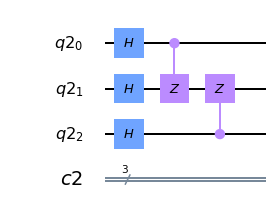

In [32]:
bcirc1 = bipartite_graph_state(B)
bcirc1.draw(output='mpl')

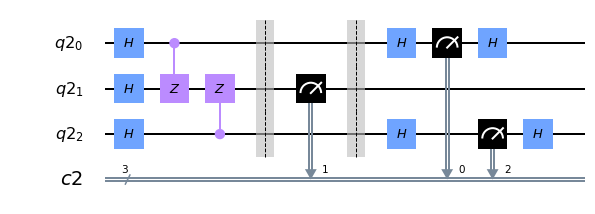

In [33]:
x_measure_white(B, bcirc1)
bcirc1.draw(output='mpl')

Notice in the circuit above how the qubit corresponding to the white nodes $\{0, 2\} \subseteq V$ are measured in the $X$-basis, and the qubit corresponding to the black node $\{1\} \subseteq V$ is measured in the $Z$-basis. Let's create a second copy of the circuit and measure using `x_measure_black()` now. 

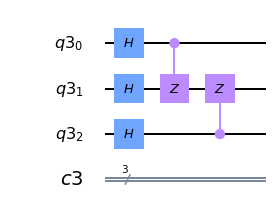

In [34]:
bcirc2 = bipartite_graph_state(B)
bcirc2.draw(output='mpl')

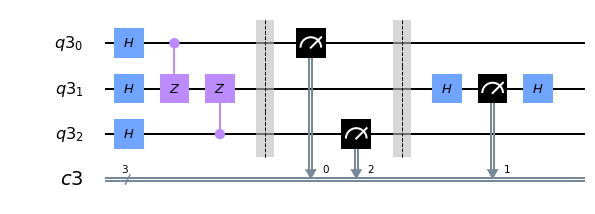

In [35]:
x_measure_black(B, bcirc2)
bcirc2.draw(output='mpl')

In this circuit the qubit corresponding to the white nodes $\{0, 2\} \subseteq V$ are measured in the $Z$-basis now, and the qubit corresponding to the black node $\{1\} \subseteq V$ is measured in the $X$-basis. 

## Example with $K_{4,3}$

Remember the graph $K_{4,3}$ from the example on creating bipartite graphs in NetworkX is created as follows. 

In [36]:
K = nx.Graph()
# Add nodes with the node attribute "bipartite"
K.add_nodes_from([0, 1, 2, 3], bipartite=0)
K.add_nodes_from([4,5,6], bipartite=1)
# Add edges only between nodes of opposite node sets
K.add_edges_from([(0, 4), (0, 5), (0, 6), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6)])

The white nodes $W$, and black nodes $B$ can be printed as follows. 

In [37]:
white_nodes, black_nodes = bipartite.sets(K)
print(white_nodes)

{0, 1, 2, 3}


In [38]:
print(black_nodes)

{4, 5, 6}


We can use the `bipartite_graph_state()` function to create the corresponding graph state, then draw the circuit. 

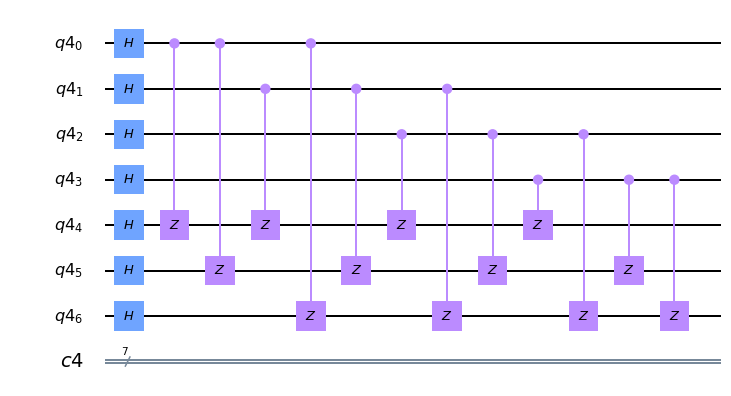

In [39]:
Kcirc = bipartite_graph_state(K)
Kcirc.draw(output='mpl')

Next, we can measure the white vertices in the $X$-basis, and the black vertices in the $Z$-basis, for a single instance of this graph state using the function `x_measure_white()`.

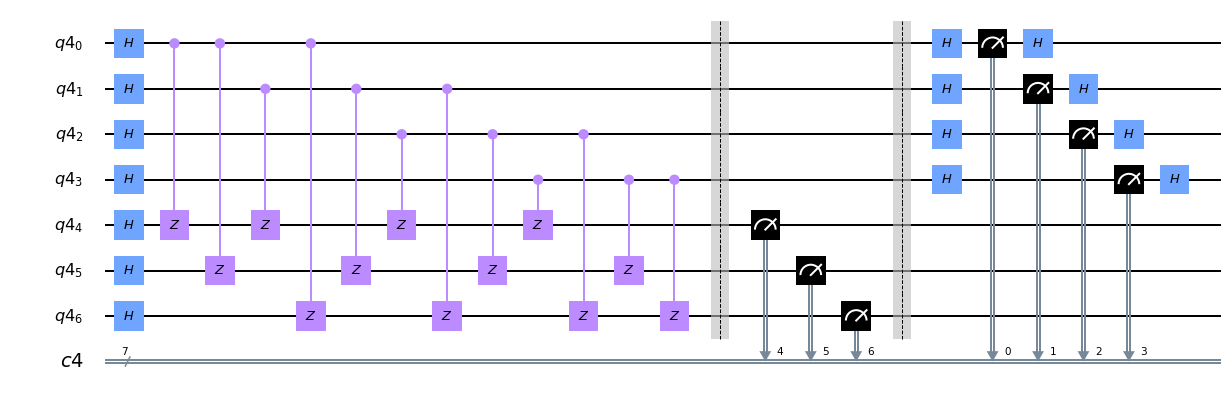

In [40]:
Kcirc = x_measure_white(K, Kcirc)
Kcirc.draw(output='mpl')

On a second copy of the circuit we can measure the white vertices in the $Z$-basis now, and the black vertices in the $X$-basis, using the function `x_measure_black()`.

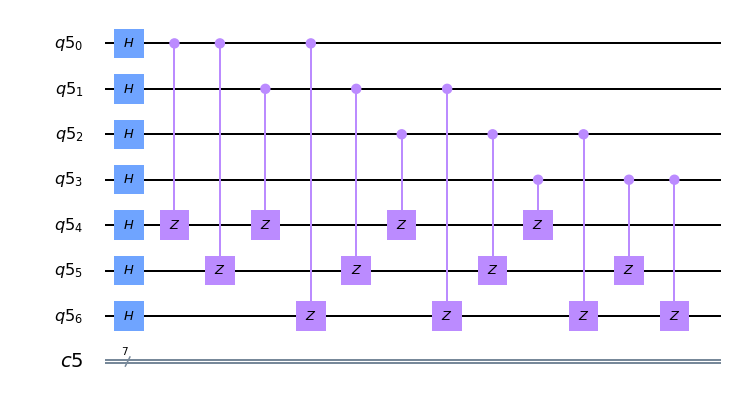

In [41]:
Kcirc2 = bipartite_graph_state(K)
Kcirc2.draw(output='mpl')

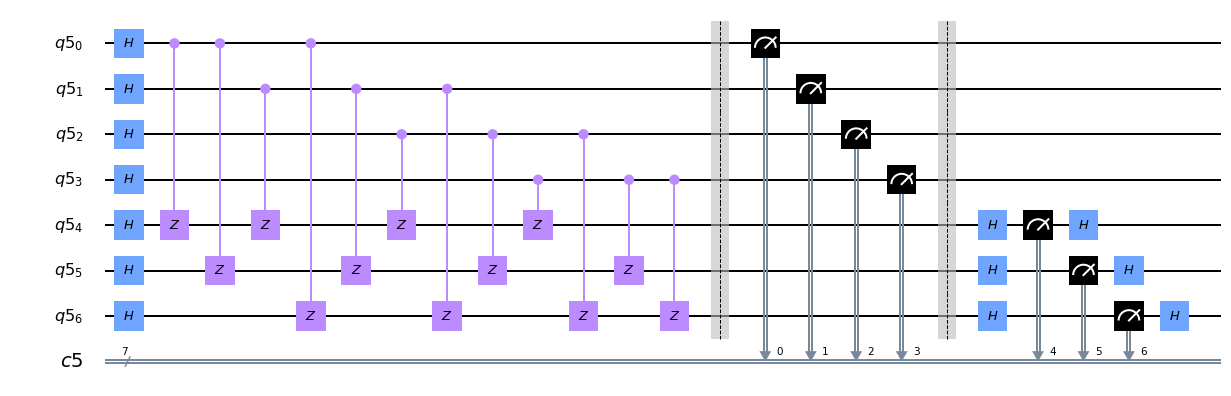

In [42]:
Kcirc2 = x_measure_black(K, Kcirc2)
Kcirc2.draw(output='mpl')

## Exercises

1. Create a graph state $|K_{3,2}\rangle$, using the bipartite graph $K_{3,2}$, with white vertices, black vertices and edges given by:
\begin{align}
W &= \{0,1,2\}\\
B &= \{4, 5\}\\
E &= \{(0,4), (0,5), (1,4), (1,5), (2,4), (2,5)\}.
\end{align}
2. Use `x_measure_white()` to measure the white vertices in the $X$-basis and the black vertices in the $Z$-basis. 
3. Create a new instance of the graph state $|K_{3,2}\rangle$ and use the function `x_measure_black()` to measure the black qubits in the $X$-basis, and the white qubits in the $Z$-basis. 
4. List all stabilizer generators for the graph state $|K_{3,2}\rangle$. 
5. Verify the stabilizer generators for $|K_{3,2}\rangle$.

## References

- ["Verifiable measurement-only blind quantum computing with stabilizer testing"](https://arxiv.org/pdf/1505.07535.pdf)